## Subclustering

In this notebook, I used TFIDF Vectorizer and NMF to produce subtopics. After a few tests, I found that 7 and 8 subtopics provided the most distinct topic sets for Politics and Business respectively.  Implementing more subtopics resulted in overlap in content.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from time import time
import spacy
from gensim.models import Word2Vec
import gensim, multiprocessing
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def nmf_cluster_unlabeled(df, vectorizer_feats = 1000, n_topics = 5):
    df = df.reset_index()
    df = df.rename(columns={'index':'original_index'})
    tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=2,
                                   max_features=vectorizer_feats,
                                   stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(df['body'])
    nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
    topic_score = pd.DataFrame(nmf.fit_transform(tfidf))
    topic_score['categ'] = topic_score[[n for n in range(n_topics)]].idxmax(axis=1)
    topic_score['categ_score'] = topic_score[[n for n in range(n_topics)]].max(axis=1)
    topic_score['categ_2score'] = pd.DataFrame(np.sort(topic_score[[n for n in range(n_topics)]].values)[:,-2:], \
                                           columns=['2nd-largest','largest'])['2nd-largest']
    topic_score['topic_diff'] = topic_score.apply(lambda row: row['categ_score'] - row['categ_2score'], axis = 1)
    #define variable to throw out scorers which are unecessary; half of 25th percentile can be changed as needed
    diff_min = {topic: topic_score[topic_score['categ']==topic].topic_diff.quantile(q=0.50) for topic in range(n_topics)}
    return(nmf, tfidf_vectorizer)

# tags parts of speech for consideration later
def marker(sentences, to_tag):
    words_final = []
    for sentence in sent_tokenize(sentences):
        for word in pos_tag(word_tokenize(sentence)):
            if word[1] in to_tag:
                words_final.append(word[0]+word[1]+"markedword")
            else:
                words_final.append(word[0])
    return ' '.join(words_final)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print("")

Using Theano backend.


In [3]:
with open('../data/pickles/model/nmf/nmf_4topics.pkl', 'rb') as f:
        nmf_models = pickle.load(f)

## Politics -- Unlabeled

In [4]:
t0 = time()

keys = sorted(nmf_models.keys())
subclusters_politics_7 = {}
category = "politics"
for key in keys:
    curr_df = nmf_models[key][0]
    nmf, tfidf = nmf_cluster_unlabeled(curr_df[curr_df['categ']==category], n_topics = 7)
    subclusters_politics_7[key] = (nmf, tfidf)
    print(key, "done in %0.3fs." % (time() - t0))

((1981, 1984), 'done in 7.932s.')
((1985, 1988), 'done in 14.223s.')
((1989, 1992), 'done in 19.222s.')
((1993, 1996), 'done in 24.511s.')
((1997, 2000), 'done in 34.074s.')
((2001, 2004), 'done in 44.470s.')
((2005, 2008), 'done in 51.644s.')
((2009, 2012), 'done in 56.223s.')
((2013, 2016), 'done in 61.124s.')


In [5]:
# Keywords for 7 Clusters -- Topics overlap
for key in keys:
    print(key)
    print_top_words(subclusters_politics_7[key][0], subclusters_politics_7[key][1].get_feature_names(), 30)
    print('--------------------------')

(1981, 1984)
Topic #0:
budget tax reagan house billion president spending cuts senate white congress democrats deficit administration committee republican year economic senator programs cut taxes republicans fiscal program percent social congressional package increases

Topic #1:
israeli israel lebanon beirut lebanese syrian palestinian israelis syria army arab forces united withdrawal begin gemayel minister troops american habib palestinians syrians states officials east military marines west christian force

Topic #2:
soviet united union states missiles american moscow nuclear reagan arms europe administration officials talks poland military haig weapons western russians west polish foreign range president missile strategic european official washington

Topic #3:
county republican district court party democratic judge election federal 000 senator attorney committee campaign justice case investigation state executive board company years mrs new chairman office mayor candidates charges

In [7]:
t0 = time()

keys = sorted(nmf_models.keys())
subclusters_politics_5 = {}
category = "politics"
for key in keys:
    curr_df = nmf_models[key][0]
    nmf, tfidf = nmf_cluster_unlabeled(curr_df[curr_df['categ']==category], n_topics = 5)
    subclusters_politics_5[key] = (nmf, tfidf)
    print(key, "done in %0.3fs." % (time() - t0))

((1981, 1984), 'done in 7.216s.')
((1985, 1988), 'done in 13.911s.')
((1989, 1992), 'done in 19.097s.')
((1993, 1996), 'done in 24.366s.')
((1997, 2000), 'done in 33.189s.')
((2001, 2004), 'done in 43.388s.')
((2005, 2008), 'done in 50.508s.')
((2009, 2012), 'done in 54.698s.')
((2013, 2016), 'done in 60.098s.')


In [9]:
# Keywords for 5 Subclusters
for key in keys:
    print(key)
    print_top_words(subclusters_politics_5[key][0], subclusters_politics_5[key][1].get_feature_names(), 30)
    print('--------------------------')

(1981, 1984)
Topic #0:
budget tax reagan house billion president spending senate cuts white congress democrats republican committee deficit year administration senator taxes republicans economic programs cut fiscal program percent social increases congressional package

Topic #1:
israeli israel lebanon beirut lebanese syrian palestinian israelis syria army arab forces united withdrawal begin minister troops gemayel american habib palestinians officials syrians military states east marines west christian government

Topic #2:
soviet united union states american missiles reagan nuclear moscow arms administration officials europe military poland talks haig weapons western president russians west polish foreign government range official missile washington strategic

Topic #3:
a1 state county governor city new court cuomo mayor republican federal district york judge 000 million year democratic koch party board years election carey company office law commission attorney justice

Topic #4:
mo

In [33]:
def nmf_cluster(df, vectorizer_feats = 1000, n_topics = 5):
    df = df.rename(columns={'index':'original_index'})
    df = df.reset_index()
    df= df.drop(['index'], axis = 1)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=2,
                               max_features=vectorizer_feats,
                               stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(df['body'])
    nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
    topic_score = pd.DataFrame(nmf.fit_transform(tfidf))
    topic_score['categ'] = topic_score[[n for n in range(n_topics)]].idxmax(axis=1)
    topic_score['categ_score'] = topic_score[[n for n in range(n_topics)]].max(axis=1)
    topic_score['categ_2score'] = pd.DataFrame(np.sort(topic_score[[n for n in range(n_topics)]].values)[:,-2:], \
                                           columns=['2nd-largest','largest'])['2nd-largest']
    topic_score['topic_diff'] = topic_score.apply(lambda row: row['categ_score'] - row['categ_2score'], axis = 1)
    df['subcat_index'] = topic_score['categ']
    topic_keys = get_clusters(nmf, tfidf_vectorizer.get_feature_names(), keywords)
    df["subcateg"] = df.apply(lambda row: topic_keys[row.subcat_index], axis=1)
    df = df.drop(['subcat_index'], axis =1)
    return(df)

thresholds = {key:4 for key in keywords.keys()}


keywords = {"Domestic": ["budget","tax", "house", "senate" ,"congress", "republicans", "deficit", "senator", \
                         "taxes", 'economic','fiscal', 'congressional', 'package', 'legislation', \
                         'policy', 'representative','vote', 'party', 'independent', 'committee','counsel',\
                        'democrats'],
            "Middle East": ["lebanon","beirut","syrian","lebanese","palestinian","palestine","arab", "syria",\
                         "syrians", "israel","israelis", 'jordan', "arafat", "hussein", "jordan", "middle",\
                           "east","kuwait", "saddam", 'afghan', 'iran', 'iraq','iraqi', 'israeli',\
                           'arabia','gaza','west', 'islam', 'islamic', 'sunni', 'isis', 'military', 'troops'\
                           'secretary','afghan', 'pakistan', 'policy', 'al', 'taliban', 'foreign', \
                            'netanyahu','intelligence'],
           "Presidential Primary": [ 'al','bob', 'brown', 'bush', 'campaign', 'candidate', 'cheney',\
                                    'clinton', 'convention', 'cruz', 'debate', 'delegates',\
                                    'democratic', 'democrats', 'dole', 'dukakis', 'edwards', 'election', 'ferraro',\
                                    'gingrich', 'gore', 'governor', 'hillary', 'iowa', 'kerry', 'mccain',\
                                    'mondale', 'nomination', 'obama', 'percent', 'perot', 'perry',\
                                    'polls', 'primary', 'race', 'reagan', 'romney', 'ross', 'rubio', 'sanders',\
                                    'santorum', 'trump','vote', 'voters', 'walter'],
           "Russia": ['soviet', 'nuclear', 'moscow', 'arms', 'europe', 'poland', 'russians', "gorbachev", \
                      "yeltsin", 'union', 'moscow','communist'],
           "State Level": ["giuliani", "election", "pataki", "lazio", "amato", "spitzer", "governor", \
                           "state", "bloomberg", "party", "mayor", "campaign",  'cuomo'],
            "Judicial Issues": ['case', 'court', 'judge', 'prosecutors', 'trial', 'lawyers', 'police', \
                                'lawyer', 'jury', 'federal', 'charges', 'justice', 'attorney', 'evidence', \
                                'law', 'investigation', 'defense', 'prison', 'department', 'criminal', 'government', \
                                'legal', 'guilty', 'cases', 'officials', 'prosecutor', 'jurors', \
                                'district'],
           "Lewinsky Scandal": ['clinton', 'president',  'house', 'white', 'starr', 'lewinsky', 'impeachment', \
                                'counsel', 'committee', 'republicans', 'mrs', 'senate', 'today', 'jones', \
                                'congress', 'independent', 'sexual', 'testimony', 'grand'],
            "Terrorism": ['bin', 'qaeda', 'laden', 'taliban', 'al', 'officials', 'intelligence', 'pakistan', \
                          'attacks', 'states', 'united', 'terrorist', 'military', \
                          'sept', '11', 'official', 'forces', 'terrorism', 'pentagon', 'information'],
            "Misclassified": ['like', 'company', 'film', 'years', 'time', 'music', 'people', 'work', \
                              'just', 'year', 'book', 'million', 'news', 'world','ms', 'movie', 'business', \
                              'life', 'executive', 'way', 'man', 'night', 'television', 'don', 'did', 'york', \
                              'nbc', 'good', 'old','hollywood']
           }

thresholds = {key:4 for key in keywords.keys()}

def get_clusters(model, feature_names, keywords, threshold = thresholds, n_top_words = 30):
    '''Labels clusters as part of categories as specified by the keywords'''
    topic_key = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_similarities = {}
        for key in keywords.keys():
            overlap = len(set(keywords[key]) & set(topic_words))
            if (key=="Local"):
                overlap = overlap*4
            if overlap>thresholds[key]:
                topic_similarities[key]  = overlap
        max_curr = 0
        for key in topic_similarities.keys():
            if topic_similarities[key] > max_curr:
                max_curr = topic_similarities[key]
                topic_key[topic_idx] = key
    print(topic_key)
    return topic_key


## Politics Labeled

In [34]:
intervals = [(m, m+3) for m in range(1981,2017,4)]

In [35]:
categ = 'politics'

t0 = time()
print intervals[0]
df = nmf_models[intervals[0]][0]
df = df[df['categ'] == categ]
df = nmf_cluster(df, n_topics = 5)
print (intervals[0], "done in %0.3fs." % (time() - t0))


for interval in intervals[1:]:
    t0 = time()
    print interval
    df_curr = nmf_models[interval][0]
    df_curr = df_curr[df_curr['categ'] == categ]
    df_curr = nmf_cluster(df_curr, n_topics=5)
    df = df.append(df_curr)
    print (interval, "done in %0.3fs." % (time() - t0))

(1981, 1984)
{0: 'Domestic', 1: 'Middle East', 2: 'Russia', 3: 'Judicial Issues', 4: 'Presidential Primary'}
((1981, 1984), 'done in 7.774s.')
(1985, 1988)
{0: 'Domestic', 1: 'Russia', 2: 'Presidential Primary', 3: 'Middle East', 4: 'Judicial Issues'}
((1985, 1988), 'done in 7.023s.')
(1989, 1992)
{0: 'Domestic', 1: 'Russia', 2: 'Middle East', 3: 'Presidential Primary', 4: 'Presidential Primary'}
((1989, 1992), 'done in 5.684s.')
(1993, 1996)
{0: 'Domestic', 1: 'Middle East', 2: 'Judicial Issues', 3: 'Presidential Primary', 4: 'Presidential Primary'}
((1993, 1996), 'done in 5.190s.')
(1997, 2000)
{0: 'State Level', 1: 'Presidential Primary', 2: 'Lewinsky Scandal', 3: 'Middle East', 4: 'Judicial Issues'}
((1997, 2000), 'done in 8.163s.')
(2001, 2004)
{0: 'Judicial Issues', 1: 'Terrorism', 2: 'Presidential Primary', 3: 'Middle East', 4: 'Terrorism'}
((2001, 2004), 'done in 10.556s.')
(2005, 2008)
{0: 'Misclassified', 1: 'Presidential Primary', 2: 'Terrorism', 3: 'State Level', 4: 'Judici

In [101]:
with open('data/pickles/model/nmf/politics_subclustered_df.pkl', 'wb') as f:
        pickle.dump(df, f)

## Business Unlabeled

In [31]:
t0 = time()

keys = sorted(nmf_models.keys())
subclusters_business_8 = {}
category = "business"
for key in keys:
    curr_df = nmf_models[key][0]
    nmf, tfidf = nmf_cluster_unlabeled(curr_df[curr_df['categ']==category], n_topics = 8)
    subclusters_business_8[key] = (nmf, tfidf)
    print(key, "done in %0.3fs." % (time() - t0))

# Keywords for 8 Clusters
for key in keys:
    print(key)
    print_top_words(subclusters_business_8[key][0], subclusters_business_8[key][1].get_feature_names(), 30)
    print('--------------------------')

((1981, 1984), 'done in 4.225s.')
((1985, 1988), 'done in 9.180s.')
((1989, 1992), 'done in 13.840s.')
((1993, 1996), 'done in 18.665s.')
((1997, 2000), 'done in 27.978s.')
((2001, 2004), 'done in 35.690s.')
((2005, 2008), 'done in 42.454s.')
((2009, 2012), 'done in 51.516s.')
((2013, 2016), 'done in 56.565s.')
(1981, 1984)
Topic #0:
d1 d4 a1 d2 prices d5 rose d6 futures market d8 columns gold fell companies international dollar tax markets d3 place economic reagan d12 ounce d10 trading york stock today

Topic #1:
tenths inflation index goods rate orders economy department economists decline economic prices commerce recovery recession growth report rise consumer increase quarter unemployment housing month months spending rates inventories production economist

Topic #2:
company million mr stock shares share companies business offer corporation industry billion years products cash chairman financial management executive analyst merger analysts 000 yesterday insurance operations investme

In [89]:
#Collect key words, tuples contain 
econ_ind = ('Econonomic Indicators',"d1 d4 a1 d2 prices d5 rose d6 futures market d8 columns gold fell companies international dollar tax markets d3 place economic reagan d12 ounce d10 trading york stock today tenths inflation index goods rate orders economy department economists decline economic prices commerce recovery recession growth report rise consumer increase quarter unemployment housing month months spending rates inventories production economist d1 d2 d4 d5 a1 d6 d8 prices economy columns market companies d3 tax place rose markets page international d10 trading fell gold economic today futures treasury million dow dollar tenths rate inflation index growth economy goods department prices report economists consumer commerce month orders economic quarter economist increase rise decline rates year spending months reported july june price rose d1 d2 d4 a1 d6 d5 advertising d8 prices d3 columns economy place page markets companies international dollar d10 market rose d7 d17 fell trading d15 futures today treasury economic rate tenths inflation index rates economy economic recession report goods fed consumer orders growth economist month quarter decline department economists prices reserve rise commerce federal increase sales labor months rose d1 d4 d2 d3 a1 d5 d6 advertising d8 columns prices page place elliott stuart economy international companies oil treasury fell rose dow million clinton d16 dollar markets d7 agreed inflation rates rate fed economy reserve federal economic tenths prices growth report index bond term economist labor month economists department goods consumer today increase higher point unemployment increases rise price fed rate inflation economy rates growth greenspan prices labor unemployment economic economist reserve federal policy economists increase jobs increases workers point higher spending quarter month 000 productivity consumer rising raise economy rate growth rates year fed economic spending quarter economists inflation prices consumer recession jobs market month cut economist unemployment months recovery 000 rose mr consumers decline government states labor")
corp = ('Corporate',"company million mr stock shares share companies business offer corporation industry billion years products cash chairman financial management executive analyst merger analysts 000 yesterday insurance operations investment american revenues debt quarter million earnings net loss income fourth reported billion second share steel cents profits operating profit company bank corporation losses results rose loans period revenues earlier 1981 1982 compared earned offer stock mr shares million share deal takeover yesterday group bid billion cash shareholders management plan corporation debt investment buy price board buyout companies 50 street chairman sale wall merger sales year industry cars computer companies market ford car products million american chrysler mr business years japanese corporation analysts united computers 000 states motors earnings auto billion period domestic machine quarter million earnings bank banks loans loss billion income loan net banking losses year fourth bankamerica reported results share citicorp assets cents profits second corporation revenues rose operating period reserves company million mr billion share quarter stock shares earnings yesterday analysts sales business deal corporation cents executive companies analyst group debt revenues years profits chairman based operating operations york price mr million stock billion shares share yesterday deal companies 000 business bank price executive shareholders corporation merger insurance years analysts industry management financial chief cents chairman largest investment health board mr million companies sales billion stock business share executive analysts shares years price yesterday industry deal products chief like executives analyst shareholders 000 management based stores earnings people corporation market company mr million deal companies business new billion year sales analysts executive industry like chief share shares today executives group market wireless united years customers cable offer stake analyst phone euros million profit billion nyt quarter year net sales loss company earlier reported rose income revenue fell period operating second earnings results compared increase share 2002 fourth half posted expected")
banking = ('Banking',"bank banks rates rate money prime loans fed funds federal savings treasury loan term reserve supply credit yield accounts market bankers week certificates institutions banking deposits short bonds billion bond banks bank loans banking estate savings loan real institutions losses deposits lending regulators federal capital citicorp insurance assets billion bankers rates credit commercial financial money deposit government rate england problems bank banks banking loans financial credit bankers morgan investment chase billion merger insurance government loan securities trust firms deutsche capital lending brokerage japan institutions assets japanese debt central merrill firm bank banks loans banking government central korea credit financial billion rates lending bad country today nyt deutsche largest loan canadian investment foreign citigroup china debt finance canada group european tokyo")
oil = ('Oil',"oil opec prices price barrel crude barrels petroleum saudi energy production countries gas gasoline nigeria companies arabia exxon day demand world gulf spot cut official mexico heating industry producers states oil opec prices crude barrel barrels production saudi price petroleum arabia gasoline energy cents countries day members organization producers industry output north world gas official demand gulf market united mexico oil gas prices russia energy production russian yukos shell natural reserves government companies day country output china foreign price fuel producer demand state largest dutch billion world company royal countries")
stocks = ('Stocks',"market stock points yesterday index issues dow stocks shares exchange trading rose composite volume average blue prices fell investors advanced climbed chip counter institutional rally jones rates technology gained record stock index market stocks dow trading points yesterday exchange futures investors rose shares volume gained issues fell day traders average composite big prices street wall record 500 blue active rally market stocks stock bonds dow points yield funds bond investors trading treasury index yesterday securities rates traders average notes exchange issues prices shares day auction week jones fund fed point oil crude prices gasoline barrels barrel price production petroleum opec cents iraq gas energy kuwait day war million gulf demand higher united fuel institute imports countries states reserves increase traders funds stocks fund stock market mutual investors dow bond points index money nasdaq bonds yesterday trading traders shares fell day average yield investment prices exchange securities rates jones cash composite stocks market investors stock trading nasdaq funds dow index fund yesterday technology day shares mutual money companies 16 points exchange earnings markets mr 500 investment week prices price internet strategist points rose c2 index dow quarter fell earnings c4 a1 sales page nasdaq d2 million jones billion industrial profit composite c6 d4 reported 500 average drug federal shares poor bond points c2 c4 index c3 nasdaq dow a1 section page c6 c5 rose 500 jones federal business world poor composite c7 stocks standard fell drug industrial c8 new bush average stock investors companies shares market options enron stocks mr funds fund trading accounting earnings executives financial money corporate exchange investment yesterday securities firms price pension company bonds firm value shareholders")
motors = ('Motor Industry',"sales cars chrysler ford period motors auto car sold units daily selling models domestic general market days makers day motor industry rate dealers american 10 million corporation reported compared manufacturers sales cars ford chrysler car auto motor trucks light models vehicles automotive makers dealers motors period sold domestic compared share japanese corporation general plant million plants earlier stores production market sales ford auto stores chrysler quarter cars 000 car store retail retailers vehicles rose trucks million earnings reported makers month light motor tenths analysts department dealers strong models gain results ford chrysler toyota vehicles detroit cars sales car auto automakers fuel trucks workers models plant gas motors industry union plants american market 000 utility gasoline production company gallon united north volkswagen cars vehicles car emissions diesel automakers vehicle auto fuel models safety driving states ford united electric owners tests german software sales europe regulators testing drivers model germany technology agency")
curr = ('Currency',"dollar rates yen japanese bank treasury japan fed foreign rate trade banks bond currency bonds deficit yield market states united central american traders markets federal reserve dollars securities west policy")
for_trade = ('Foreign Trade','japanese japan american companies united states computer industry technology chips market trade foreign semiconductor computers chip business government machines makers research say europe world european tokyo company electronics years like japan japanese yen trade american dollar united states foreign deficit government exports mexico currency imports tokyo surplus countries companies world billion cars officials mexican administration economic markets market auto european japan yen japanese currency asia dollar government united states south american economic korea foreign asian markets trade countries china crisis economy kong hong deficit exports brazil euro world country oil yen japan billion japanese sales nyt year trillion exports fiscal profit tokyo march motor corporation ended largest expects grew sony toyota company forecast electronics earned period 31 trade motors demand china chinese beijing united trade japan american states foreign exports government currency world rare countries india global solar energy export japanese factories economic officials factory international country companies power goods china chinese beijing government renminbi hong kong foreign shanghai country market economy currency united states state growth markets companies economic global world american overseas local party trade officials factories international')
technology = ('Technology',"cable bell communications telephone television distance service companies phone local atlantic warner services network cellular wireless mci tele networks long programming customers nynex telecommunications competition systems time viacom video media computer microsoft software internet apple computers personal technology machines pc windows intel industry line business market operating chips systems digital corporation network electronic information data chip use product research products microsoft software windows computer operating internet antitrust pc technology judge netscape government justice computers web intel personal case department court industry apple systems office digital users compaq business programs suit internet cable communications service wireless online phone companies distance local web telephone television bell network deal telecommunications warner com access customers mci services media worldcom networks long telecom america sites google microsoft yahoo advertising internet online software search web ads media ad sites users site technology company revenue video service cable warner apple phone digital computer network music companies com apple sales google technology software million business customers industry products mobile consumers data apple google mobile facebook microsoft users software samsung devices iphone technology internet app search apps phone phones ads data companies tech smartphone smartphones privacy people amazon services twitter advertising information")
retail = ('Retail','mart wal stores sales retailers store retail chain season consumers target products like customers consumer prices food spending company rose ms analysts buy home department analyst health open brand friday')
euro = ('Euro','european greece euro debt europe greek zone spain germany countries bonds euros italy central bank german banks fund bailout union crisis portugal leaders france spanish markets ireland billion bond government')
healthcare = ('Healthcare','drug drugs dr patients health doctors medical care company agency study hospitals hospital approval approved insurers products use food safety studies federal makers people companies law used industry problems states drug drugs patients dr health doctors care medical insurers patient hospitals price insurance companies approved prices use cost approval costs federal used research products plans study tests johnson coverage sales')
govt = ('Government','state workers tax health jobs government people 000 pension states federal benefits city care work million job pay money budget taxes officials law public program years employees labor insurance percent')

In [90]:
strs = [econ_ind, corp, banking, oil, stocks, motors, curr, for_trade, technology, retail, euro, healthcare, govt]

In [91]:
##Find most common key words
keywords={}
for t in strs:
    a = t[1].split(' ')
    d = {x:a.count(x) for x in a}
    a, b = d.keys(), d.values()
    highest = sorted(d.values(),reverse=True)
    top = min(len(highest), 30)
    all_keys = [a[i] for i, j in enumerate(b) if j in set(highest[:25])]
    keywords[t[0]] = all_keys


In [98]:
for t in keywords.keys():
    print(t, len(keywords[t]))
thresholds = {key:4 for key in keywords.keys()}


('Oil', 25)
('Government', 30)
('Currency', 30)
('Technology', 50)
('Healthcare', 42)
('Motor Industry', 33)
('Euro', 30)
('Banking', 25)
('Econonomic Indicators', 43)
('Retail', 30)
('Stocks', 32)
('Corporate', 29)
('Foreign Trade', 35)


In [99]:
categ = 'business'

t0 = time()
print intervals[0]
df_bus = nmf_models[intervals[0]][0]
df_bus = df_bus[df_bus['categ'] == categ]
df_bus = nmf_cluster(df_bus, n_topics = 8)
print (intervals[0], "done in %0.3fs." % (time() - t0))


for interval in intervals[1:]:
    t0 = time()
    print interval
    df_curr = nmf_models[interval][0]
    df_curr = df_curr[df_curr['categ'] == categ]
    df_curr = nmf_cluster(df_curr, n_topics=8)
    df_bus = df_bus.append(df_curr)
    print (interval, "done in %0.3fs." % (time() - t0))

(1981, 1984)
{0: 'Econonomic Indicators', 1: 'Econonomic Indicators', 2: 'Corporate', 3: 'Banking', 4: 'Oil', 5: 'Stocks', 6: 'Motor Industry', 7: 'Corporate'}
((1981, 1984), 'done in 4.143s.')
(1985, 1988)
{0: 'Econonomic Indicators', 1: 'Corporate', 2: 'Econonomic Indicators', 3: 'Stocks', 4: 'Oil', 5: 'Currency', 6: 'Motor Industry', 7: 'Corporate'}
((1985, 1988), 'done in 4.585s.')
(1989, 1992)
{0: 'Corporate', 1: 'Econonomic Indicators', 2: 'Econonomic Indicators', 3: 'Banking', 4: 'Foreign Trade', 5: 'Stocks', 6: 'Oil', 7: 'Motor Industry'}
((1989, 1992), 'done in 4.401s.')
(1993, 1996)
{0: 'Corporate', 1: 'Econonomic Indicators', 2: 'Econonomic Indicators', 3: 'Motor Industry', 4: 'Foreign Trade', 5: 'Technology', 6: 'Technology', 7: 'Stocks'}
((1993, 1996), 'done in 4.821s.')
(1997, 2000)
{0: 'Corporate', 1: 'Stocks', 2: 'Foreign Trade', 3: 'Technology', 4: 'Econonomic Indicators', 5: 'Stocks', 6: 'Technology', 7: 'Banking'}
((1997, 2000), 'done in 8.363s.')
(2001, 2004)
{0: 'C

In [100]:
with open('data/pickles/model/nmf/business_subclustered_df.pkl', 'wb') as f:
        pickle.dump(df_bus, f)

# Summary of Subclusters

In [103]:
with open('../data/pickles/model/nmf/politics_subclustered_df.pkl', 'rb') as f:
    df_politics = pickle.load(f)
    
with open('../data/pickles/model/nmf/business_subclustered_df.pkl', 'rb') as f:
    df_business = pickle.load(f)

In [104]:
df = df_politics.append(df_business)
df.head()

,original_index,url,body,pub_year,categ,subcateg
0,4,https://www.nytimes.com/1981/01/03/us/gop-is-a...,"\n \nUsing campaign contributions, computer pr...",1981.0,politics,Local
1,7,https://www.nytimes.com/1981/01/02/world/hua-g...,\n \nThe first official indication of the down...,1981.0,politics,Local
2,25,https://www.nytimes.com/1981/03/02/us/reagan-m...,"\n \nAs much as $40 million, in addition to th...",1981.0,politics,Domestic
3,27,https://www.nytimes.com/1981/03/04/us/presiden...,\n \nPresident Reagan said today that he saw n...,1981.0,politics,Russia
4,28,https://www.nytimes.com/1981/03/04/nyregion/ca...,\n \nGovernor Carey submitted to the Legislatu...,1981.0,politics,Local


In [105]:
print(df.shape)
print(df[df['categ']=='politics'].shape)
print(df[df['categ']=='business'].shape)

(78996, 6)
(38485, 6)
(40511, 6)


In [108]:
def time_period(integer, intervals):
    for interval in intervals:
        if (integer<=interval[1]) & (integer>=interval[0]):
            return interval

df['interval'] = df['pub_year'].apply(time_period,args = (intervals,))

In [192]:
grouped = df[['interval','categ','subcateg','url']].groupby(['interval','categ','subcateg']).agg(['count'])['url']
grouped = grouped.reset_index()

grouped = grouped[(grouped['categ']=='politics') & (grouped['subcateg']!='Misclassified')]
politics = grouped[grouped['categ'] == 'politics']
politics_subcategs = politics.subcateg.unique()
subcateg_years = {}
subcateg_counts = []
subcategs = []
for subcateg in politics_subcategs:
    subcateg_years[subcateg] = sorted(list(politics[politics['subcateg']==subcateg]['interval'].unique()))

for key in subcateg_years.keys():
    subcateg_counts.append(len(sorted(subcateg_years[key])))
    subcategs.append(key)

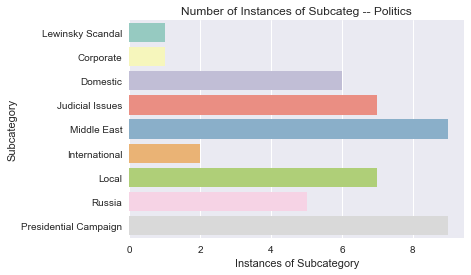

In [193]:
sns.barplot(subcateg_counts, subcategs, palette="Set3")
plt.xlabel('Instances of Subcategory')
plt.ylabel('Subcategory')
plt.title('Number of Instances of Subcateg -- Politics')
plt.savefig('foo3.png')

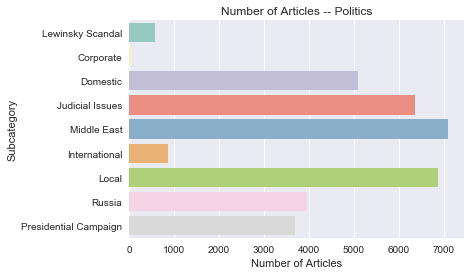

In [194]:
art_counts = grouped[(grouped['categ']=='politics')]\
.groupby('subcateg').agg(['sum'])['count']['sum']

sns.barplot([art_counts[sub] for sub in subcategs],subcategs, palette="Set3")
plt.xlabel('Number of Articles')
plt.ylabel('Subcategory')
plt.title('Number of Articles -- Politics')
plt.savefig('foo3.png')

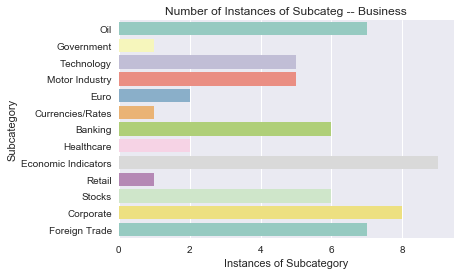

In [168]:
business = grouped[grouped['categ'] == 'business']
business_subcategs = business.subcateg.unique()
subcateg_years = {}
subcateg_counts = []
subcategs = []
for subcateg in business_subcategs:
    subcateg_years[subcateg] = sorted(list(business[business['subcateg']==subcateg]['interval'].unique()))

for key in subcateg_years.keys():
    subcateg_counts.append(len(sorted(subcateg_years[key])))
    subcategs.append(key)
    
sns.barplot(subcateg_counts,subcategs, palette="Set3")
plt.ylabel('Subcategory')
plt.xlabel('Instances of Subcategory')
plt.title('Number of Instances of Subcateg -- Business')
plt.savefig('foo4.png')

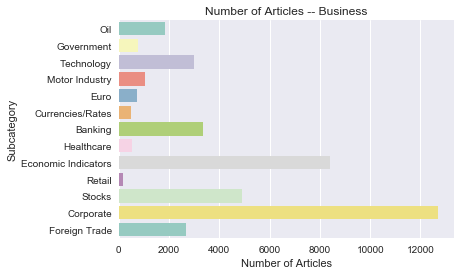

In [176]:
art_counts = grouped[(grouped['categ']=='business') & (grouped['subcateg']!='Misclassified')]\
.groupby('subcateg').agg(['sum'])['count']['sum']

sns.barplot([art_counts[sub] for sub in subcategs],subcategs, palette="Set3")
plt.xlabel('Number of Articles')
plt.ylabel('Subcategory')
plt.title('Number of Articles -- Business')
plt.savefig('foo3.png')